# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

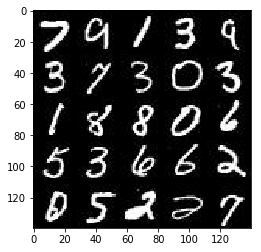

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

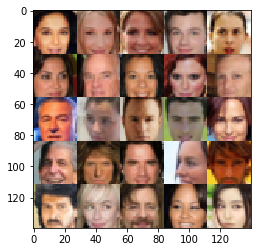

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(
        tf.float32, 
        (None, image_width, image_height, image_channels), 
        name="input_real")
    
    inputs_z = tf.placeholder(
        tf.float32, 
        (None, z_dim), 
        name="input_z")
    
    learning_rate = tf.placeholder(tf.float32, shape=(None), name="learning_rate")
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, trainable=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        net1 = tf.layers.dense(z, 4*4*512)
        net1 = tf.reshape(net1, (-1, 4, 4, 512))
        net1 = tf.layers.batch_normalization(net1, training=is_train)
        net1 = tf.maximum(alpha*net1, net1)
        
        conv1 = tf.layers.conv2d_transpose(net1, 256, 4, strides=1, padding='valid')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, 
                                            strides=2, padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10
    show_every = 100
    
    # TODO: Build Model
    # (60000, 28, 28, 1)
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, 
                                                   image_height, 
                                                   image_channels,
                                                   z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={
                    input_z: batch_z,
                    input_real: batch_images,
                    learn_rate: learning_rate
                })
                
                _ = sess.run(g_opt, feed_dict={
                    input_z: batch_z,
                    input_real: batch_images,
                    learn_rate: learning_rate
                })
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 20, input_z, image_channels, data_image_mode)
    print("--End--")

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1672... Generator Loss: 2.2478
Epoch 1/2... Discriminator Loss: 0.0949... Generator Loss: 3.7901
Epoch 1/2... Discriminator Loss: 0.2935... Generator Loss: 4.8331
Epoch 1/2... Discriminator Loss: 0.0880... Generator Loss: 3.4839
Epoch 1/2... Discriminator Loss: 0.0135... Generator Loss: 4.5206
Epoch 1/2... Discriminator Loss: 0.5324... Generator Loss: 2.0432
Epoch 1/2... Discriminator Loss: 0.4669... Generator Loss: 2.5862
Epoch 1/2... Discriminator Loss: 0.1827... Generator Loss: 3.8422
Epoch 1/2... Discriminator Loss: 0.1353... Generator Loss: 5.1702
Epoch 1/2... Discriminator Loss: 0.0305... Generator Loss: 4.3583


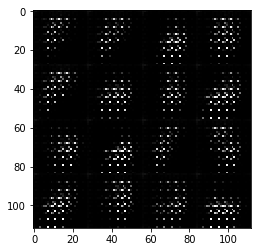

Epoch 1/2... Discriminator Loss: 0.3197... Generator Loss: 2.9059
Epoch 1/2... Discriminator Loss: 0.5085... Generator Loss: 2.5437
Epoch 1/2... Discriminator Loss: 0.2823... Generator Loss: 2.2774
Epoch 1/2... Discriminator Loss: 1.4876... Generator Loss: 0.5126
Epoch 1/2... Discriminator Loss: 0.5160... Generator Loss: 1.4454
Epoch 1/2... Discriminator Loss: 0.4777... Generator Loss: 1.6833
Epoch 1/2... Discriminator Loss: 0.6360... Generator Loss: 1.3701
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.6433
Epoch 1/2... Discriminator Loss: 0.8611... Generator Loss: 4.6016
Epoch 1/2... Discriminator Loss: 0.5190... Generator Loss: 1.7046


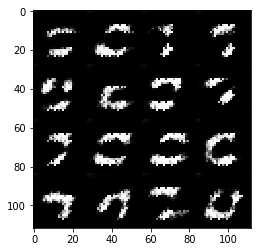

Epoch 1/2... Discriminator Loss: 0.9149... Generator Loss: 2.7674
Epoch 1/2... Discriminator Loss: 0.5608... Generator Loss: 1.9365
Epoch 1/2... Discriminator Loss: 0.9041... Generator Loss: 1.0773
Epoch 1/2... Discriminator Loss: 0.8157... Generator Loss: 1.3964
Epoch 1/2... Discriminator Loss: 0.9476... Generator Loss: 1.1728
Epoch 1/2... Discriminator Loss: 0.3849... Generator Loss: 3.1224
Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 1.9923
Epoch 1/2... Discriminator Loss: 0.5518... Generator Loss: 1.4378
Epoch 1/2... Discriminator Loss: 0.9181... Generator Loss: 0.8729
Epoch 1/2... Discriminator Loss: 1.0019... Generator Loss: 0.7359


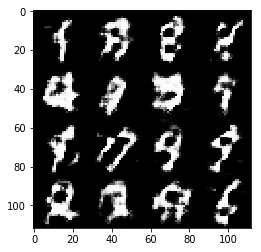

Epoch 1/2... Discriminator Loss: 1.1115... Generator Loss: 1.8697
Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 0.9897
Epoch 1/2... Discriminator Loss: 0.8197... Generator Loss: 1.4395
Epoch 1/2... Discriminator Loss: 1.0671... Generator Loss: 1.9506
Epoch 1/2... Discriminator Loss: 0.8773... Generator Loss: 0.8467
Epoch 1/2... Discriminator Loss: 1.0973... Generator Loss: 0.6768
Epoch 1/2... Discriminator Loss: 0.9528... Generator Loss: 1.7419
Epoch 1/2... Discriminator Loss: 1.2019... Generator Loss: 1.6366
Epoch 1/2... Discriminator Loss: 0.9947... Generator Loss: 1.1712
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.5112


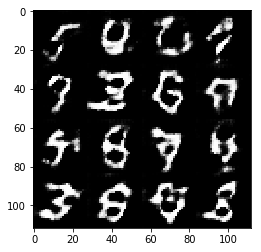

Epoch 1/2... Discriminator Loss: 1.0151... Generator Loss: 2.0671
Epoch 1/2... Discriminator Loss: 0.8231... Generator Loss: 1.6548
Epoch 1/2... Discriminator Loss: 1.0003... Generator Loss: 0.9570
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 1.6142
Epoch 1/2... Discriminator Loss: 0.8349... Generator Loss: 1.6994
Epoch 1/2... Discriminator Loss: 0.8930... Generator Loss: 0.8899
Epoch 1/2... Discriminator Loss: 1.1173... Generator Loss: 2.0859
Epoch 1/2... Discriminator Loss: 0.9146... Generator Loss: 1.1698
Epoch 1/2... Discriminator Loss: 1.0026... Generator Loss: 1.5557
Epoch 1/2... Discriminator Loss: 0.9722... Generator Loss: 0.8821


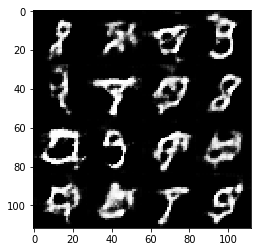

Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 0.6072
Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 0.4850
Epoch 1/2... Discriminator Loss: 0.8954... Generator Loss: 1.1823
Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 0.7887
Epoch 1/2... Discriminator Loss: 1.0660... Generator Loss: 1.5492
Epoch 1/2... Discriminator Loss: 1.4774... Generator Loss: 0.4147
Epoch 1/2... Discriminator Loss: 1.0472... Generator Loss: 0.8713
Epoch 1/2... Discriminator Loss: 1.0761... Generator Loss: 0.7216
Epoch 1/2... Discriminator Loss: 1.5391... Generator Loss: 0.4267
Epoch 1/2... Discriminator Loss: 1.0995... Generator Loss: 1.1749


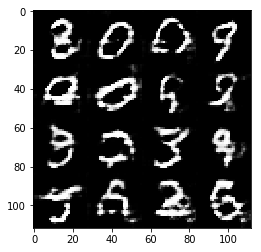

Epoch 1/2... Discriminator Loss: 0.9652... Generator Loss: 1.1238
Epoch 1/2... Discriminator Loss: 0.9038... Generator Loss: 1.8243
Epoch 1/2... Discriminator Loss: 0.9153... Generator Loss: 1.3793
Epoch 1/2... Discriminator Loss: 0.8869... Generator Loss: 0.9292
Epoch 1/2... Discriminator Loss: 1.1466... Generator Loss: 0.6063
Epoch 1/2... Discriminator Loss: 0.9891... Generator Loss: 0.8284
Epoch 1/2... Discriminator Loss: 0.8159... Generator Loss: 1.1789
Epoch 1/2... Discriminator Loss: 0.9659... Generator Loss: 1.3232
Epoch 1/2... Discriminator Loss: 0.9867... Generator Loss: 1.0533
Epoch 1/2... Discriminator Loss: 1.1735... Generator Loss: 1.9308


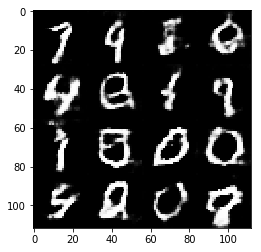

Epoch 1/2... Discriminator Loss: 0.9124... Generator Loss: 1.0798
Epoch 1/2... Discriminator Loss: 1.1672... Generator Loss: 0.6775
Epoch 1/2... Discriminator Loss: 1.2308... Generator Loss: 0.6521
Epoch 1/2... Discriminator Loss: 0.9279... Generator Loss: 1.2634
Epoch 1/2... Discriminator Loss: 0.9503... Generator Loss: 0.9964
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.8043
Epoch 1/2... Discriminator Loss: 0.8639... Generator Loss: 1.7197
Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 1.6303
Epoch 1/2... Discriminator Loss: 1.0510... Generator Loss: 0.8837
Epoch 1/2... Discriminator Loss: 0.9965... Generator Loss: 1.1199


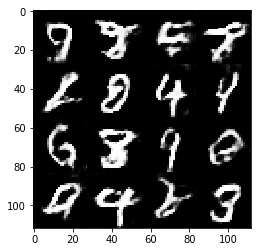

Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 2.0668
Epoch 1/2... Discriminator Loss: 0.9132... Generator Loss: 1.6275
Epoch 1/2... Discriminator Loss: 1.0324... Generator Loss: 1.3941
Epoch 1/2... Discriminator Loss: 0.9729... Generator Loss: 1.4801
Epoch 1/2... Discriminator Loss: 0.9463... Generator Loss: 1.1458
Epoch 1/2... Discriminator Loss: 0.9425... Generator Loss: 1.4118
Epoch 1/2... Discriminator Loss: 1.0283... Generator Loss: 1.5382
Epoch 1/2... Discriminator Loss: 0.9586... Generator Loss: 1.6132
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 1.9092
Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 1.2657


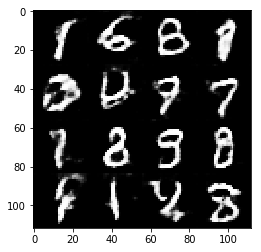

Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 1.2070
Epoch 1/2... Discriminator Loss: 1.1280... Generator Loss: 1.0842
Epoch 1/2... Discriminator Loss: 0.9715... Generator Loss: 1.1055
Epoch 2/2... Discriminator Loss: 0.8876... Generator Loss: 0.9498
Epoch 2/2... Discriminator Loss: 0.9253... Generator Loss: 1.0761
Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 1.3566
Epoch 2/2... Discriminator Loss: 0.9144... Generator Loss: 0.7903
Epoch 2/2... Discriminator Loss: 1.6178... Generator Loss: 0.3367
Epoch 2/2... Discriminator Loss: 1.1791... Generator Loss: 0.7116
Epoch 2/2... Discriminator Loss: 1.0062... Generator Loss: 0.8497


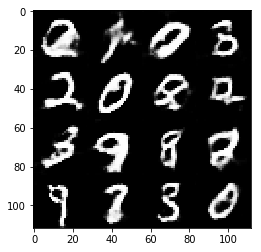

Epoch 2/2... Discriminator Loss: 0.8623... Generator Loss: 1.9290
Epoch 2/2... Discriminator Loss: 1.3340... Generator Loss: 0.6739
Epoch 2/2... Discriminator Loss: 1.0827... Generator Loss: 0.9368
Epoch 2/2... Discriminator Loss: 1.6292... Generator Loss: 0.4336
Epoch 2/2... Discriminator Loss: 0.9154... Generator Loss: 1.1554
Epoch 2/2... Discriminator Loss: 1.3169... Generator Loss: 0.6037
Epoch 2/2... Discriminator Loss: 1.3621... Generator Loss: 2.3154
Epoch 2/2... Discriminator Loss: 1.0139... Generator Loss: 0.8989
Epoch 2/2... Discriminator Loss: 0.9762... Generator Loss: 0.7988
Epoch 2/2... Discriminator Loss: 0.9531... Generator Loss: 1.1041


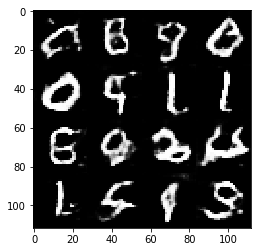

Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 0.5805
Epoch 2/2... Discriminator Loss: 0.9163... Generator Loss: 1.5789
Epoch 2/2... Discriminator Loss: 0.9647... Generator Loss: 1.3635
Epoch 2/2... Discriminator Loss: 0.7297... Generator Loss: 1.8026
Epoch 2/2... Discriminator Loss: 1.0939... Generator Loss: 0.7076
Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 1.1336
Epoch 2/2... Discriminator Loss: 1.6496... Generator Loss: 0.3404
Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 0.8921
Epoch 2/2... Discriminator Loss: 0.7997... Generator Loss: 1.0302
Epoch 2/2... Discriminator Loss: 0.8924... Generator Loss: 1.0698


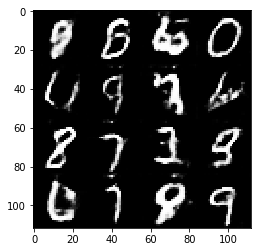

Epoch 2/2... Discriminator Loss: 1.5519... Generator Loss: 0.3734
Epoch 2/2... Discriminator Loss: 0.7675... Generator Loss: 1.0524
Epoch 2/2... Discriminator Loss: 2.3390... Generator Loss: 3.6267
Epoch 2/2... Discriminator Loss: 0.7795... Generator Loss: 1.6312
Epoch 2/2... Discriminator Loss: 0.7552... Generator Loss: 1.3788
Epoch 2/2... Discriminator Loss: 0.8124... Generator Loss: 1.3318
Epoch 2/2... Discriminator Loss: 0.8166... Generator Loss: 1.2887
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 1.5733
Epoch 2/2... Discriminator Loss: 0.9290... Generator Loss: 1.1422
Epoch 2/2... Discriminator Loss: 0.8969... Generator Loss: 1.0928


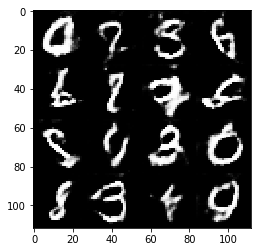

Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 1.7618
Epoch 2/2... Discriminator Loss: 1.2935... Generator Loss: 0.5188
Epoch 2/2... Discriminator Loss: 0.8845... Generator Loss: 1.0129
Epoch 2/2... Discriminator Loss: 0.7774... Generator Loss: 1.0161
Epoch 2/2... Discriminator Loss: 1.4377... Generator Loss: 2.8057
Epoch 2/2... Discriminator Loss: 0.7563... Generator Loss: 1.3159
Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 2.0487
Epoch 2/2... Discriminator Loss: 0.7487... Generator Loss: 1.2500
Epoch 2/2... Discriminator Loss: 1.1209... Generator Loss: 0.6192
Epoch 2/2... Discriminator Loss: 0.8397... Generator Loss: 1.2284


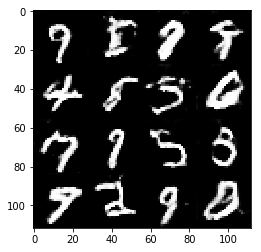

Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 0.7528
Epoch 2/2... Discriminator Loss: 0.9287... Generator Loss: 1.7047
Epoch 2/2... Discriminator Loss: 1.4694... Generator Loss: 0.4524
Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 0.7758
Epoch 2/2... Discriminator Loss: 1.1622... Generator Loss: 0.7920
Epoch 2/2... Discriminator Loss: 0.8230... Generator Loss: 1.0116
Epoch 2/2... Discriminator Loss: 0.8761... Generator Loss: 1.1462
Epoch 2/2... Discriminator Loss: 0.8642... Generator Loss: 1.6940
Epoch 2/2... Discriminator Loss: 1.6231... Generator Loss: 2.7446
Epoch 2/2... Discriminator Loss: 0.8210... Generator Loss: 1.3269


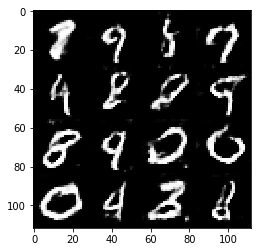

Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 0.9719
Epoch 2/2... Discriminator Loss: 1.1563... Generator Loss: 2.2346
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 0.9064
Epoch 2/2... Discriminator Loss: 1.2147... Generator Loss: 0.8348
Epoch 2/2... Discriminator Loss: 0.9279... Generator Loss: 0.9017
Epoch 2/2... Discriminator Loss: 1.7231... Generator Loss: 0.3594
Epoch 2/2... Discriminator Loss: 0.9022... Generator Loss: 1.8446
Epoch 2/2... Discriminator Loss: 0.6420... Generator Loss: 1.3995
Epoch 2/2... Discriminator Loss: 0.9733... Generator Loss: 2.6281
Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 1.3168


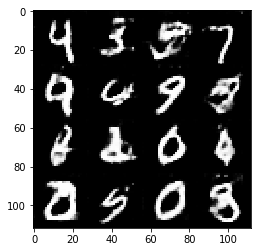

Epoch 2/2... Discriminator Loss: 0.7919... Generator Loss: 1.1335
Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 1.7223
Epoch 2/2... Discriminator Loss: 1.5836... Generator Loss: 0.3833
Epoch 2/2... Discriminator Loss: 0.8390... Generator Loss: 2.0509
Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 0.7882
Epoch 2/2... Discriminator Loss: 0.6910... Generator Loss: 1.7320
Epoch 2/2... Discriminator Loss: 1.2434... Generator Loss: 3.0584
Epoch 2/2... Discriminator Loss: 0.6095... Generator Loss: 1.6434
Epoch 2/2... Discriminator Loss: 0.8235... Generator Loss: 1.0456
Epoch 2/2... Discriminator Loss: 0.8782... Generator Loss: 1.2012


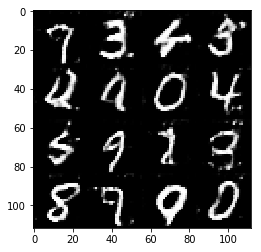

Epoch 2/2... Discriminator Loss: 1.1049... Generator Loss: 1.1922
Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 1.2845
Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 2.1330
Epoch 2/2... Discriminator Loss: 1.1042... Generator Loss: 0.7607
Epoch 2/2... Discriminator Loss: 0.8657... Generator Loss: 1.0141
Epoch 2/2... Discriminator Loss: 0.7144... Generator Loss: 1.5665
Epoch 2/2... Discriminator Loss: 1.0956... Generator Loss: 2.6911
Epoch 2/2... Discriminator Loss: 0.7823... Generator Loss: 1.2655
Epoch 2/2... Discriminator Loss: 0.9856... Generator Loss: 2.4805
Epoch 2/2... Discriminator Loss: 0.7548... Generator Loss: 1.3068


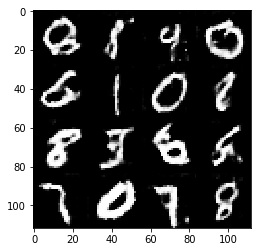

Epoch 2/2... Discriminator Loss: 0.8342... Generator Loss: 1.8691
Epoch 2/2... Discriminator Loss: 1.7884... Generator Loss: 0.3937
Epoch 2/2... Discriminator Loss: 0.8167... Generator Loss: 1.3048
Epoch 2/2... Discriminator Loss: 0.7338... Generator Loss: 1.4099
Epoch 2/2... Discriminator Loss: 0.8998... Generator Loss: 0.9637
Epoch 2/2... Discriminator Loss: 0.9590... Generator Loss: 0.7381
Epoch 2/2... Discriminator Loss: 0.9147... Generator Loss: 1.1201
--End--


In [27]:
batch_size = 64
z_dim = 128
learning_rate = .001
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 5.6023
Epoch 1/1... Discriminator Loss: 1.8004... Generator Loss: 9.2630
Epoch 1/1... Discriminator Loss: 2.0387... Generator Loss: 6.1089
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 1.6101
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.4452
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.4358
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 1.0307


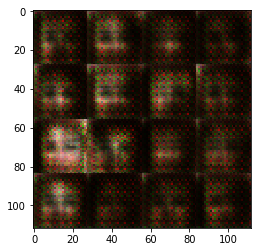

Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 1.7470
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 1.3654
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.4268
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 2.6140... Generator Loss: 3.6683
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 2.1246
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 0.7892... Generator Loss: 0.8465


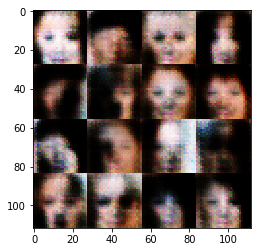

Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 2.0917
Epoch 1/1... Discriminator Loss: 0.4280... Generator Loss: 2.8537
Epoch 1/1... Discriminator Loss: 0.2750... Generator Loss: 5.1653
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 1.2387
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 2.4772
Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.3186
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.4390
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.3487
Epoch 1/1... Discriminator Loss: 1.7587... Generator Loss: 0.2666
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.3800


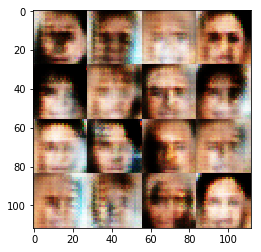

Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 0.7363... Generator Loss: 1.3079
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.5630
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.5142
Epoch 1/1... Discriminator Loss: 0.5932... Generator Loss: 3.2366
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 1.9858
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.4532
Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 2.8951
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.6887


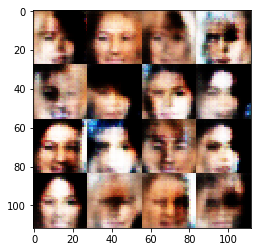

Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 2.4252
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 1.3693
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 0.1779... Generator Loss: 2.6606
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.3661
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 1.2296
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 1.9561
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 1.8398


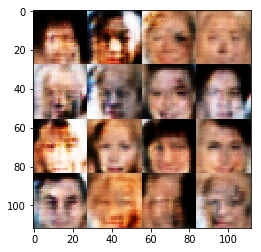

Epoch 1/1... Discriminator Loss: 0.3758... Generator Loss: 2.2024
Epoch 1/1... Discriminator Loss: 2.2912... Generator Loss: 0.3472
Epoch 1/1... Discriminator Loss: 1.9348... Generator Loss: 0.2273
Epoch 1/1... Discriminator Loss: 1.9423... Generator Loss: 0.1975
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.3742
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.5689
Epoch 1/1... Discriminator Loss: 0.2917... Generator Loss: 4.6821
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 0.9331


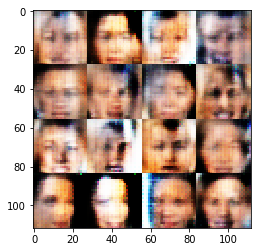

Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.5824... Generator Loss: 0.3282
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 1.6895... Generator Loss: 0.3026
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.4178
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 0.7517


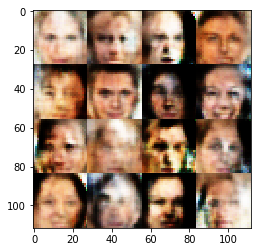

Epoch 1/1... Discriminator Loss: 1.6461... Generator Loss: 0.3139
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 0.1305... Generator Loss: 4.1179
Epoch 1/1... Discriminator Loss: 0.7157... Generator Loss: 1.5352
Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 1.5308
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 1.6354... Generator Loss: 0.2903
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.3533
Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 1.7207
Epoch 1/1... Discriminator Loss: 0.8248... Generator Loss: 1.9586


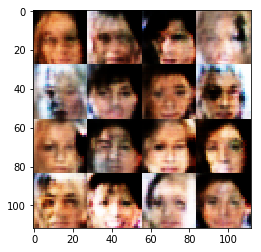

Epoch 1/1... Discriminator Loss: 0.8294... Generator Loss: 1.5874
Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.9332
Epoch 1/1... Discriminator Loss: 0.6593... Generator Loss: 1.3575
Epoch 1/1... Discriminator Loss: 1.6037... Generator Loss: 2.1506
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 2.6618
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 1.3317
Epoch 1/1... Discriminator Loss: 0.7462... Generator Loss: 2.6087
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.3286
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.5231
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 1.2346


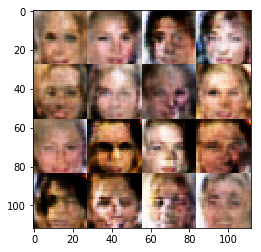

Epoch 1/1... Discriminator Loss: 0.7217... Generator Loss: 1.2241
Epoch 1/1... Discriminator Loss: 0.7347... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 2.1078... Generator Loss: 0.2136
Epoch 1/1... Discriminator Loss: 1.5356... Generator Loss: 0.3106
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 1.2849
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.3423
Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 1.6589
Epoch 1/1... Discriminator Loss: 1.9323... Generator Loss: 0.2163


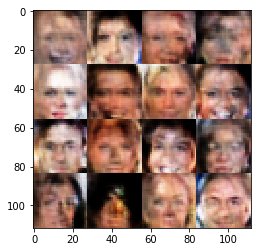

Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.5001
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 3.7334
Epoch 1/1... Discriminator Loss: 0.5197... Generator Loss: 2.4085
Epoch 1/1... Discriminator Loss: 0.1993... Generator Loss: 4.2118
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 1.3570
Epoch 1/1... Discriminator Loss: 0.1411... Generator Loss: 3.1717
Epoch 1/1... Discriminator Loss: 0.1645... Generator Loss: 5.4087
Epoch 1/1... Discriminator Loss: 0.1003... Generator Loss: 4.1305


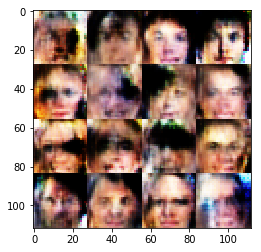

Epoch 1/1... Discriminator Loss: 0.0655... Generator Loss: 5.1088
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 4.9847
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 1.5447
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 2.1594
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.3459
Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 1.6294
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.8120
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 1.8800
Epoch 1/1... Discriminator Loss: 2.2681... Generator Loss: 3.4505


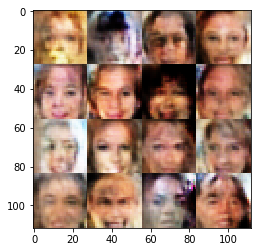

Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.9369
Epoch 1/1... Discriminator Loss: 0.7293... Generator Loss: 1.7120
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.9931
Epoch 1/1... Discriminator Loss: 0.5668... Generator Loss: 1.6908
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 2.0043
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 2.6299
Epoch 1/1... Discriminator Loss: 0.6293... Generator Loss: 1.3984
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.4032
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 2.9363
Epoch 1/1... Discriminator Loss: 0.7660... Generator Loss: 2.1675


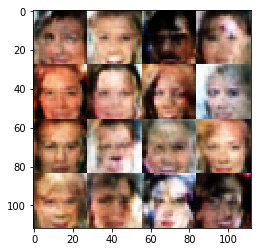

Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 3.0659
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 2.0008
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 2.4230
Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 1.1960
Epoch 1/1... Discriminator Loss: 2.0287... Generator Loss: 0.2637
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.3922
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.2485


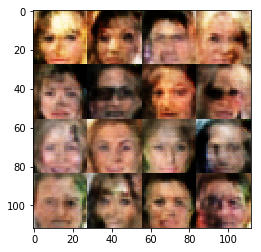

Epoch 1/1... Discriminator Loss: 0.4412... Generator Loss: 1.7213
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.9249
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.8122


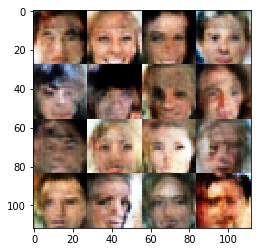

Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 1.8706
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.3800
Epoch 1/1... Discriminator Loss: 1.9461... Generator Loss: 3.0992
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 2.0187
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 2.3789
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 0.5041... Generator Loss: 2.5405
Epoch 1/1... Discriminator Loss: 1.5932... Generator Loss: 2.1497
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 0.8190


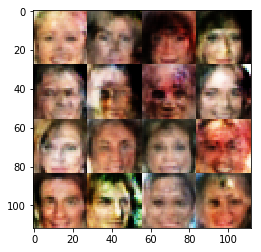

Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.4197
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 0.1205... Generator Loss: 4.3890
Epoch 1/1... Discriminator Loss: 0.2211... Generator Loss: 2.9003
Epoch 1/1... Discriminator Loss: 0.2317... Generator Loss: 3.0040
Epoch 1/1... Discriminator Loss: 0.0637... Generator Loss: 4.7392
Epoch 1/1... Discriminator Loss: 0.6222... Generator Loss: 1.3335


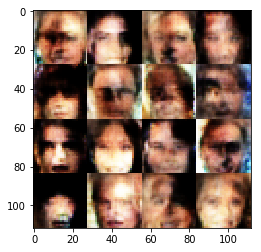

Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 1.3592
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 1.9646
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 2.3913
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.4829
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 2.3806
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 0.7461... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 0.5203... Generator Loss: 1.5313
Epoch 1/1... Discriminator Loss: 1.7764... Generator Loss: 0.2509


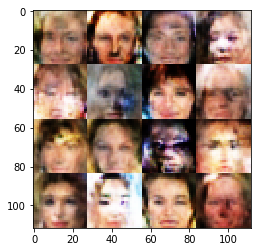

Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.4674
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 2.5262
Epoch 1/1... Discriminator Loss: 0.4358... Generator Loss: 1.7416
Epoch 1/1... Discriminator Loss: 0.3052... Generator Loss: 1.8967
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.6682
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 0.8285... Generator Loss: 1.5910


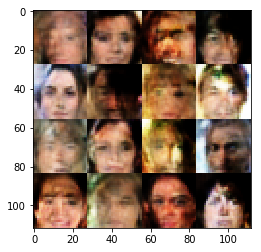

Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 1.3382
Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 1.1034
Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 2.2697
Epoch 1/1... Discriminator Loss: 0.1645... Generator Loss: 4.0582
Epoch 1/1... Discriminator Loss: 1.6760... Generator Loss: 0.3456
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.4059
Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 2.4070
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.8667
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 1.8175
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 2.1229


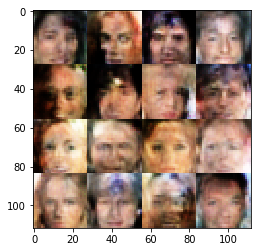

Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 2.8977
Epoch 1/1... Discriminator Loss: 0.6008... Generator Loss: 1.8425
Epoch 1/1... Discriminator Loss: 1.6147... Generator Loss: 3.5666
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 1.7159
Epoch 1/1... Discriminator Loss: 0.7189... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.3578
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.3712
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 2.1737


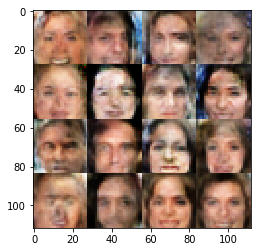

Epoch 1/1... Discriminator Loss: 0.2977... Generator Loss: 2.0586
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 3.3405
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.3431
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 2.2641
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 2.1751
Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 1.6715
Epoch 1/1... Discriminator Loss: 0.7717... Generator Loss: 1.7404
Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 1.7082
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 2.1885


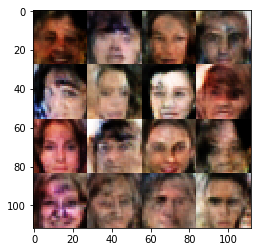

Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.8383
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 0.1569... Generator Loss: 3.3963
Epoch 1/1... Discriminator Loss: 0.4033... Generator Loss: 1.9740
Epoch 1/1... Discriminator Loss: 1.7194... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.2877
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 2.0864
Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 1.4518
Epoch 1/1... Discriminator Loss: 0.6068... Generator Loss: 1.7376
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 3.1551


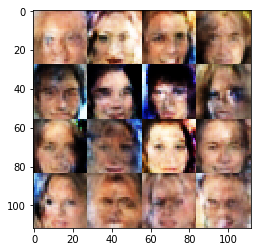

Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 1.5085
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.7756... Generator Loss: 2.9946
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 1.2794
Epoch 1/1... Discriminator Loss: 1.6125... Generator Loss: 0.3984
Epoch 1/1... Discriminator Loss: 0.4849... Generator Loss: 1.8281
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 1.2163
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 3.5698
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.5356


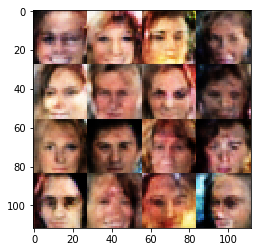

Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 3.0992
Epoch 1/1... Discriminator Loss: 0.5649... Generator Loss: 1.4231
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 2.4363
Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 1.2528
Epoch 1/1... Discriminator Loss: 1.6863... Generator Loss: 0.2858
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 0.1879... Generator Loss: 2.7698
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 2.2939
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 2.4499
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 2.1878


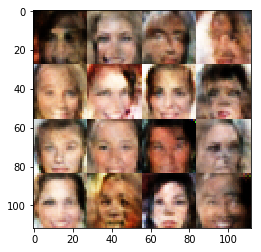

Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 1.8886
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 3.1049
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 1.1085
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.4375
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 0.3928... Generator Loss: 1.5569
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 0.2044... Generator Loss: 2.7518
Epoch 1/1... Discriminator Loss: 0.1239... Generator Loss: 3.5029
Epoch 1/1... Discriminator Loss: 0.3151... Generator Loss: 2.1032


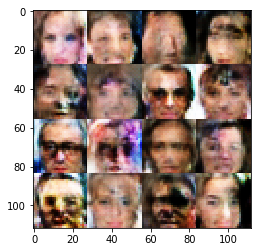

Epoch 1/1... Discriminator Loss: 0.4792... Generator Loss: 2.2247
Epoch 1/1... Discriminator Loss: 0.0381... Generator Loss: 6.5243
Epoch 1/1... Discriminator Loss: 1.6892... Generator Loss: 0.3069
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.4098
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 2.9064
Epoch 1/1... Discriminator Loss: 0.7409... Generator Loss: 1.3137
Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 1.4809
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 1.2467
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 0.7658


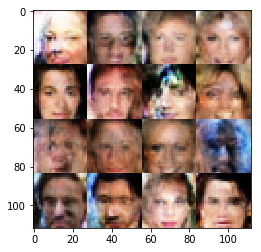

Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.4257
Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 1.3998
Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.6079... Generator Loss: 0.3115
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 0.4767... Generator Loss: 1.8181
Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 1.5027
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 1.6087


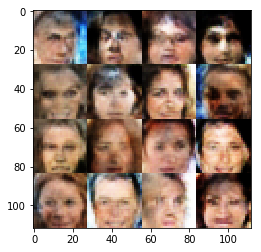

Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 0.8311... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 3.8724
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.4081
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.3957
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 0.5392... Generator Loss: 1.4464


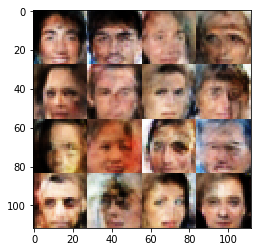

Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 1.9491
Epoch 1/1... Discriminator Loss: 2.8715... Generator Loss: 0.0894
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 0.6852... Generator Loss: 3.4102
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.4554
Epoch 1/1... Discriminator Loss: 1.7258... Generator Loss: 0.2908
Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 1.2794
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.4258
Epoch 1/1... Discriminator Loss: 0.6009... Generator Loss: 1.0867


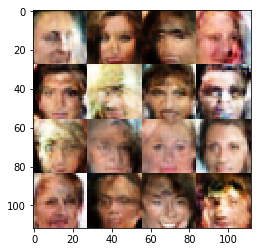

Epoch 1/1... Discriminator Loss: 0.7792... Generator Loss: 1.4693
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 2.1340
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 2.4869
Epoch 1/1... Discriminator Loss: 0.5428... Generator Loss: 2.7155
Epoch 1/1... Discriminator Loss: 1.7296... Generator Loss: 4.0142
Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 2.1284
Epoch 1/1... Discriminator Loss: 0.7455... Generator Loss: 1.6856
Epoch 1/1... Discriminator Loss: 0.5154... Generator Loss: 2.3225
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.4417
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.6737


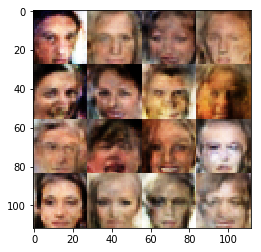

Epoch 1/1... Discriminator Loss: 0.5264... Generator Loss: 1.9495
Epoch 1/1... Discriminator Loss: 0.3070... Generator Loss: 1.9366
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 2.9920
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.6853... Generator Loss: 0.3399
Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 2.1702
--End--


In [13]:
batch_size = 64
z_dim = 128
learning_rate = .001
beta1 = .1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.